# Imports

In [1]:
import unidecode, folium
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [2]:
PATH_OUT = Path('data/processed/criminality')

# Preprocess

In [3]:
PATH_OUT.mkdir(parents=True, exist_ok=True)

In [87]:
df_pop = pd.read_csv('data/raw/inei_series.csv')
df_pop.columns = [unidecode.unidecode(e.lower()) for e in df_pop.columns]

[e for e in [i for i in df_pop.indicador.unique() if 'Pobla' in i]
    if df_pop[df_pop.indicador == e].set_index('ambito').sum(axis=1).sum() > 0]

['Población censada urbana', 'Población censada rural']

In [88]:
df_pop = df_pop[df_pop.indicador.isin(['Población censada urbana', 'Población censada rural'])]
df_pop = df_pop.applymap(lambda x: '' if x == '-' else x)
cols = [k for k,v in df_pop.iloc[:, 3:].sum().iteritems() if v > 0]
df_pop = df_pop.loc[:, ['ambito', 'indicador']+cols]
df_pop.ambito = df_pop.ambito.apply(lambda x: unidecode.unidecode(x.strip()))
df_pop.indicador = df_pop.indicador.apply(lambda x: unidecode.unidecode(x.lower().replace(' ', '_')))
df_pop.to_csv(PATH_OUT/'population_inei.csv', index=False)
df_pop.head(2)

,ambito,indicador,1940,1961,1972,1981,1993,2007
2,Amazonas,poblacion_censada_urbana,26648.0,45977,67357,81973,119517,166003
5,Amazonas,poblacion_censada_rural,38489.0,72462,127115,172587,217148,209990


In [192]:
df = (pd.read_csv('data/raw/criminality/tipo-ubicacion.csv').
          drop('Periodo', axis=1).
          T.reset_index())
df.iat[0,0] = 'year'
df.iat[0,1] = 'departamento'
df.columns = df.iloc[0].apply(lambda x: unidecode.unidecode(x.lower().replace(' ', '-')))
df.drop(0, inplace=True)
df.reset_index(drop=True, inplace=True)
y = df.loc[0, 'year']
for i,row in df.iterrows():
    if row.year.isdigit():
        y = row.year
    row.year = y

df.year = df.year.astype(int)
df.departamento = (df.departamento.
                     str.title().
                     str.replace('Lima Provincias 2/', 'Lima Provincias').
                     str.replace('Provincia De Lima 1/', 'Lima').
                     str.replace('Provincia Constitucional Del Callao', 'Callao').
                     str.replace(' De ', ' de '))
df = df.melt(id_vars=['year', 'departamento'], var_name='variable')
df.value = df.value.str.replace(' ', '').fillna(0).astype(int)
df.to_csv(PATH_OUT/'tipo-ubicacion.csv', index=False)
df = df.set_index(['year', 'departamento', 'variable'])
df.head(2)

value
year departamento variable       
2015 Amazonas     generica      0
     Ancash       generica      0

# Views

In [3]:
df_pop = pd.read_csv(PATH_OUT/'population_inei.csv')
df_pop = df_pop.set_index(['ambito', 'indicador'])['2007'].fillna(0).unstack().reset_index()
df_pop.columns.name = None
df_pop['poblacion_censada_total'] = df_pop.poblacion_censada_rural + df_pop.poblacion_censada_urbana
df = pd.read_csv(PATH_OUT/'tipo-ubicacion.csv')
df.loc[df.departamento == 'Lima Provincias', 'departamento'] = 'Lima'
df = (df.groupby(['year', 'departamento', 'variable']).sum().reset_index().
          merge(df_pop, 'left', left_on='departamento', right_on='ambito').
          assign(ratio = lambda x: x.value / x.poblacion_censada_total).
          assign(poblacion = lambda x: x.poblacion_censada_total).
          set_index(['year', 'departamento', 'variable'])[['value', 'ratio', 'poblacion']])

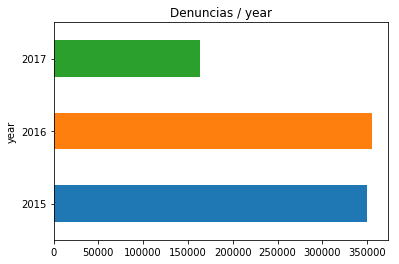

In [4]:
df.groupby('year')['value'].sum().plot.barh(title='Denuncias / year');

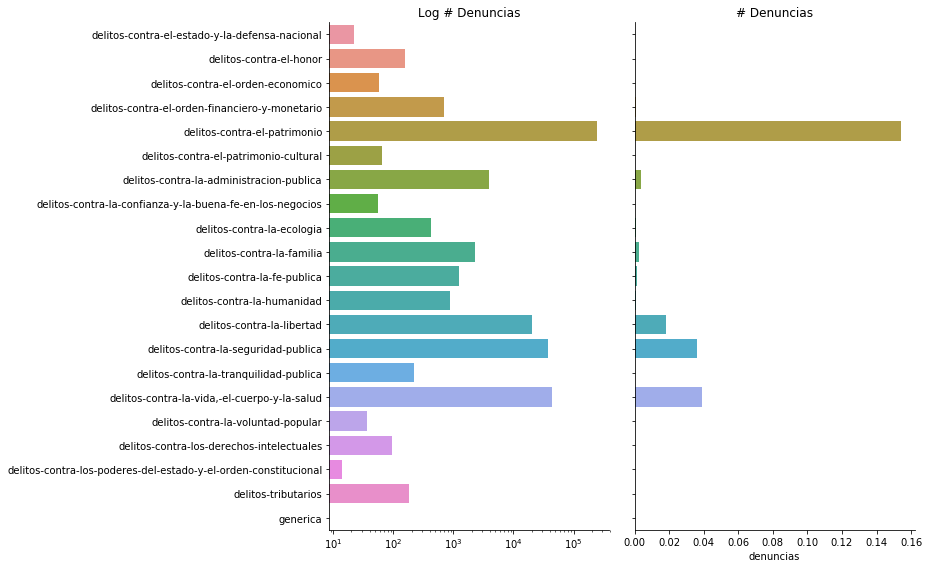

In [368]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(13,8))

df_denuncias = (df.loc[2016].
                   groupby('variable').
                   agg({'value': 'sum', 'ratio': 'sum', 'poblacion': 'mean'}).
                   reset_index().
                   assign(value_perc=lambda x: x.value / x.value.sum()))

sns.barplot(df_denuncias.value, df_denuncias.variable, ax=axes[0])
axes[0].set_title('Log # Denuncias')
axes[0].set_xlabel('')
axes[0].set_xscale('log')

sns.barplot(df_denuncias.ratio, df_denuncias.variable, ax=axes[1])
axes[1].set_title('# Denuncias')
axes[1].set_xlabel('denuncias')

for ax in axes: ax.set_ylabel('')
plt.tight_layout()
sns.despine()

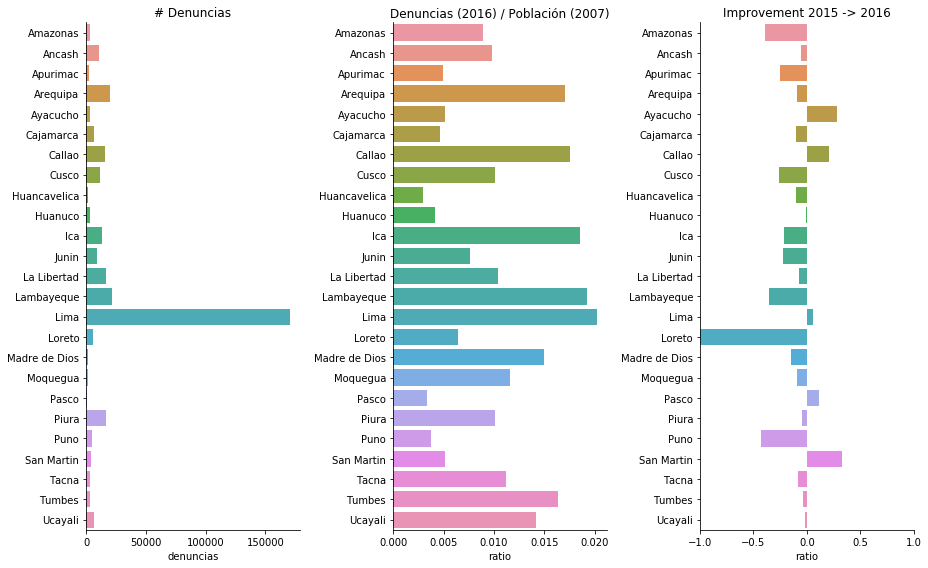

In [183]:
fig, axes = plt.subplots(1, 3, figsize=(13,8))

df_departments = (df.loc[2016].
                     groupby('departamento').
                     agg({'value': 'sum', 'ratio': 'sum', 'poblacion': 'mean'}).
                     reset_index())

sns.barplot(df_departments.value, df_departments.departamento, ax=axes[0])
axes[0].set_title('# Denuncias')
axes[0].set_xlabel('denuncias')

sns.barplot(df_departments.ratio, df_departments.departamento, ax=axes[1])
axes[1].set_title('Denuncias (2016) / Población (2007)')
axes[1].set_xlabel('ratio')

t = df.groupby(['year', 'departamento'])['value'].sum()
t = ((t[2015] - t[2016]) / t[2015]).reset_index()
sns.barplot('value', 'departamento', data=t, ax=axes[2])
axes[2].set_title('Improvement 2015 -> 2016')
axes[2].set_xlabel('ratio')
axes[2].set_xlim(-1,1)

for ax in axes: ax.set_ylabel('')
plt.tight_layout()
sns.despine()

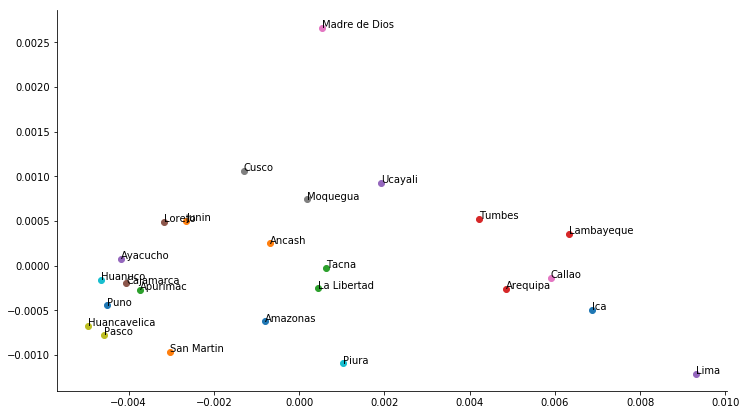

In [188]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(2)
t = df.loc[2016, 'ratio'].unstack(0).T

plt.figure(figsize=(12,7))
t_pca = pca.fit_transform(t)
for n,(x,y) in zip(t.index, t_pca):
    plt.plot(x, y, 'o')
    plt.text(x, y, n)
    
sns.despine()

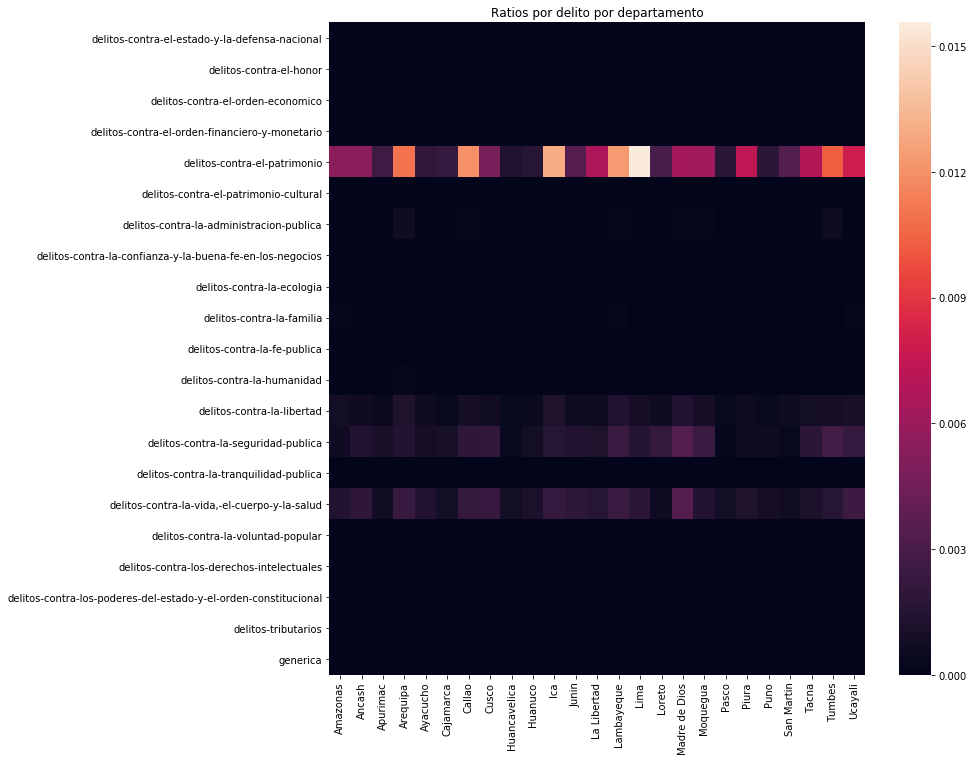

In [189]:
plt.figure(figsize=(12,12))
sns.heatmap(t.T)
plt.xlabel(''); plt.ylabel('')
plt.title('Ratios por delito por departamento');

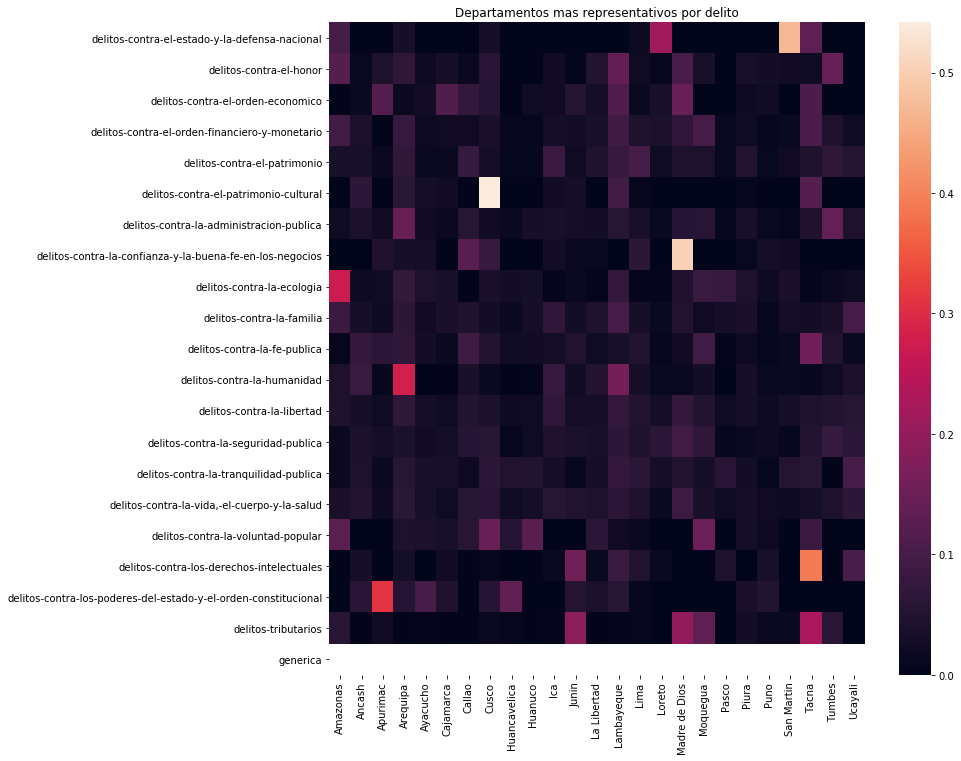

In [190]:
plt.figure(figsize=(12,12))
t = df.loc[2016, 'ratio'].unstack(0).T
sns.heatmap(t.apply(lambda x: x/x.sum(), axis=0).T)
plt.xlabel(''); plt.ylabel('')
plt.title('Departamentos mas representativos por delito');

# Maps

In [321]:
geos = (gpd.read_file('data/raw/peru_departamental_simple.geojson').
            assign(NOMBDEP=lambda x: x.NOMBDEP.str.title().str.replace('De', 'de')).
            merge(df_departments, 'left', left_on='NOMBDEP', right_on='departamento').
            set_index('NOMBDEP').
            loc[:, ['geometry', 'value', 'ratio', 'poblacion']])
geos.head(2)

,geometry,value,ratio,poblacion
NOMBDEP,,,,
Amazonas,POLYGON ((-77.75893361195118 -6.96450785011829...,3340,0.008883,375993.0
Ancash,POLYGON ((-77.31748636153681 -8.53015235157666...,10446,0.009823,1063459.0


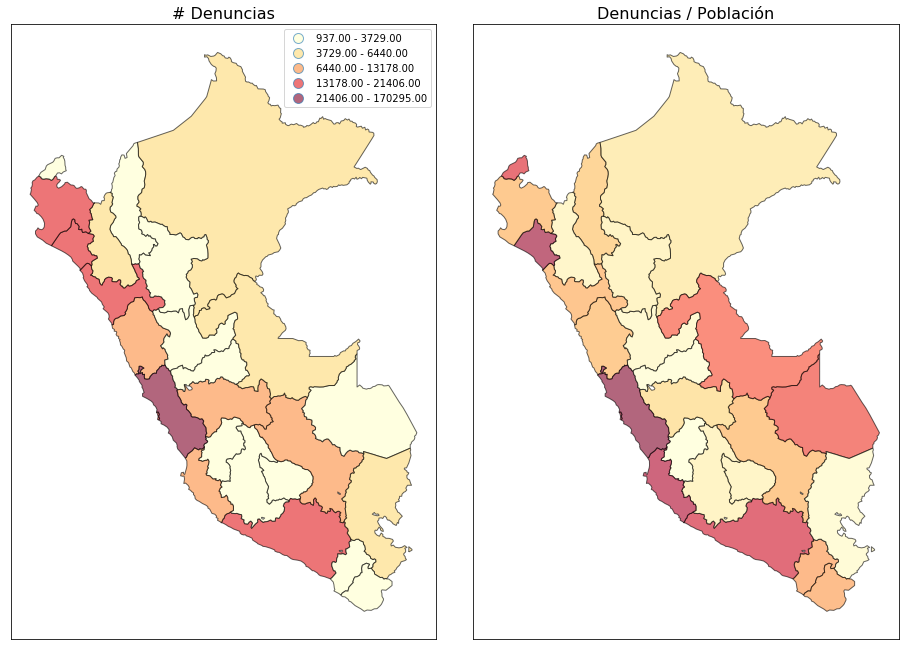

In [322]:
fig, axs = plt.subplots(1, 2, figsize=(13,9))

titles = ['# Denuncias', 'Denuncias / Población']
geos.plot(column='value', cmap='YlOrRd', scheme='Fisher_Jenks',
          legend=True, alpha=.6, edgecolor='black', ax=axs[0])
geos.plot(column='ratio', cmap='YlOrRd',# scheme='equal_interval',
          legend=False, alpha=.6, edgecolor='black', ax=axs[1])

for ax,t in zip(axs,titles):
    ax.set_title(t, fontdict={'fontsize': 16}); ax.set_xticks([]);ax.set_yticks([]);ax.set_aspect('equal')
    
plt.tight_layout()

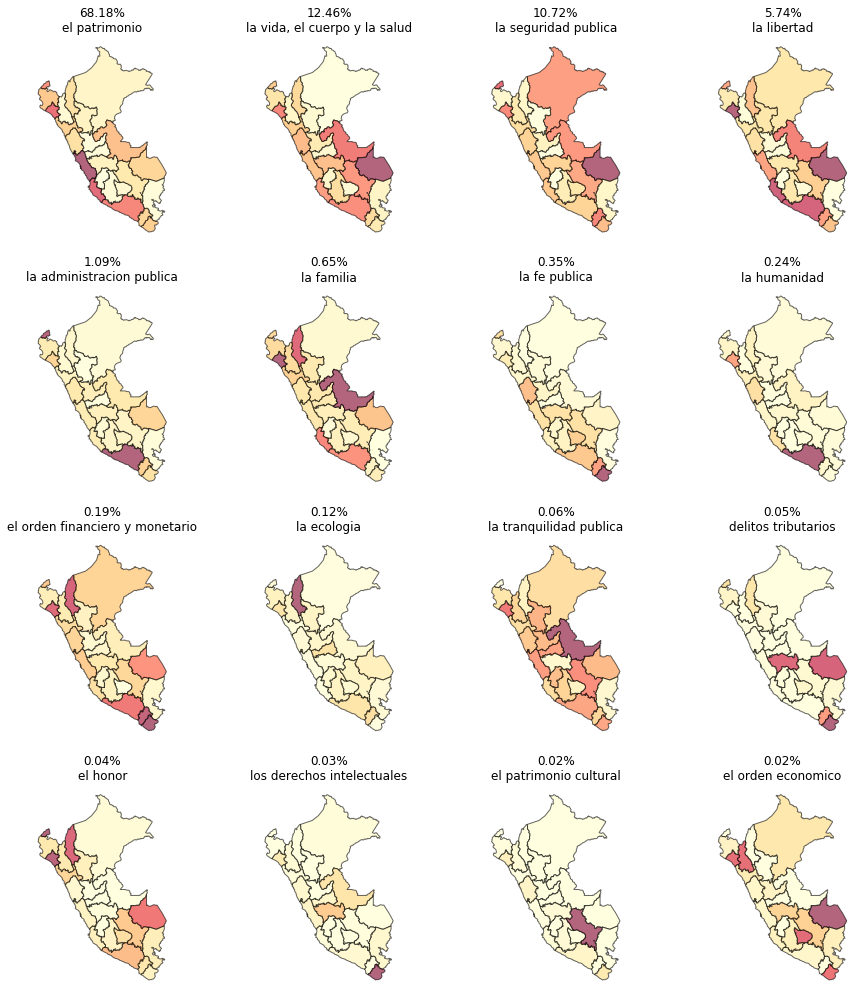

In [419]:
fig, axes = plt.subplots(4, 4, figsize=(13,14))

for ax,e in zip(axes.flatten(), df_denuncias.sort_values('value', ascending=False).variable):
    v = df_denuncias.query(f'variable == {e!r}').value_perc.iloc[0] * 100
    df_t = (df.loc[pd.IndexSlice[2016,:,e]].
               groupby('departamento').
               agg({'value': 'sum', 'ratio': 'sum', 'poblacion': 'mean'}).
               reset_index())
    df_t = (geos[['geometry']].
               merge(df_t, 'left', left_index=True, right_on='departamento'))#.set_index('departamento'))
    df_t.plot(column='ratio', cmap='YlOrRd',
              legend=False, alpha=.6, edgecolor='black', ax=ax)
    ax.set_title(f'{v:.2f}%\n{e.replace("delitos-contra-", "").replace("-"," ")}', fontdict={'fontsize': 12})
    ax.set_xticks([]);ax.set_yticks([]);ax.set_aspect('equal')
    ax.set_axis_off()
    
plt.tight_layout()